In [66]:
from src.model import Transformer, TransformerConfig
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
transformer = Transformer(TransformerConfig(10, 10, 2, num_blocks=2, embedding_size=64))
test_input = torch.LongTensor([[1,5,2,3,4,1], [1,1,1,1,1,6]])
transformer(test_input)

tensor([[[6.2181e-14, 9.9999e-01, 6.0463e-16, 2.4105e-11, 2.3305e-14,
          6.0437e-17, 2.0967e-14, 4.2513e-15, 6.3042e-06, 6.5140e-19],
         [7.2628e-09, 6.3067e-06, 2.5678e-06, 1.8474e-08, 2.1360e-04,
          9.9840e-01, 4.1308e-08, 2.2075e-08, 1.0486e-04, 1.2677e-03],
         [2.1728e-11, 3.0505e-16, 1.0000e+00, 2.3629e-12, 6.4585e-12,
          1.0348e-20, 6.9496e-11, 1.3904e-17, 2.4508e-09, 3.4972e-16],
         [3.3442e-08, 2.9863e-06, 2.6957e-09, 7.8824e-01, 9.0635e-14,
          8.8183e-19, 4.1502e-09, 7.6394e-16, 2.1176e-01, 3.6888e-14],
         [1.7627e-09, 5.1915e-12, 2.2339e-11, 6.6847e-14, 1.0000e+00,
          2.3779e-18, 2.2225e-14, 3.1723e-18, 2.3186e-11, 1.6673e-15],
         [1.5488e-15, 1.0000e+00, 1.1630e-16, 5.5333e-20, 3.1566e-20,
          6.4008e-22, 9.8788e-22, 1.8144e-22, 1.4102e-15, 1.2350e-22]],

        [[3.7483e-11, 9.9999e-01, 6.3598e-16, 7.1718e-11, 3.7834e-09,
          4.7717e-13, 6.7138e-13, 5.9246e-11, 8.4922e-06, 6.6505e-16],
         [7

In [54]:
# Expectation: should be able to predict the next word with 100% accuracy, except for the last word, where it should be undecided between "working" and "broken"
sentences = ["this transformer is working <end>", "this transformer is broken <end>"]
words = {"this": 0, "transformer": 1, "is": 2, "working": 3, "broken": 4, "<end>": 5}
training_data = torch.LongTensor([[words[word] for word in example.split(" ")] for example in sentences])
y = torch.LongTensor([[words[word] for word in example.split(" ")[1:]] + [words["<end>"]] for example in sentences]).view(-1)
print(training_data)
print(y)


tensor([[0, 1, 2, 3, 5],
        [0, 1, 2, 4, 5]])
tensor([1, 2, 3, 5, 5, 1, 2, 4, 5, 5])


In [61]:
one_hot_y = nn.functional.one_hot(y, num_classes=6).float()
transformer = Transformer(TransformerConfig(vocab_size=6, max_input_length=5, num_heads=2, num_blocks=2, embedding_size=16))
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(transformer.parameters())

for i in range(10000):
    x = transformer(training_data)
    x = x.view(-1, x.shape[-1])
    loss = loss_fn(x, one_hot_y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i%999 == 0:
        print(f"Step: {i}, loss: {loss}")

Step: 0, loss: 0.24771340191364288
Step: 999, loss: 0.022415004670619965
Step: 1998, loss: 0.01663365587592125
Step: 2997, loss: 0.017362035810947418
Step: 3996, loss: 0.01559241022914648
Step: 4995, loss: 0.015530895441770554
Step: 5994, loss: 0.016533201560378075
Step: 6993, loss: 0.01883033663034439
Step: 7992, loss: 0.014311639592051506
Step: 8991, loss: 0.019013868644833565
Step: 9990, loss: 0.01794053241610527


In [69]:
x = transformer(training_data).detach()
x = np.round(x.view(-1, x.shape[-1]).numpy(), 2)
print("Predicted class probabilities")
print(x)
print("True class probabilites")
print(one_hot_y.numpy())


Predicted class probabilities
[[0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.55 0.44 0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.49 0.5  0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   1.  ]]
True class probabilites
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


<Axes: >

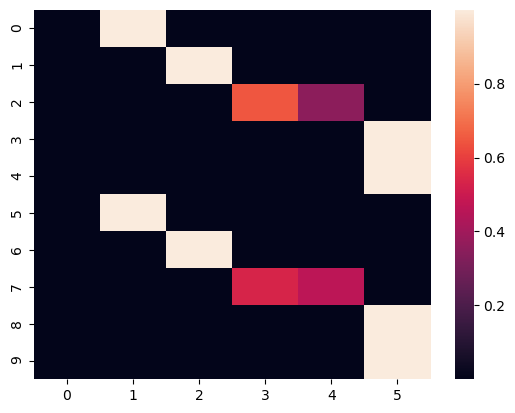

In [63]:
x = transformer(training_data).detach()
x = x.view(-1, x.shape[-1])
sns.heatmap(x)